# Table of Contents

### [1. Preparations](#chapter1)
### [2. Model training](#chapter2)
#### [2.1 TF-IDF](#chapter2.1)
- [Preprocessing](#chapter2.1.1)
- [Train classical statistical models](#chapter2.1.2)
- [Error analysis](#chapter2.1.3)
- [Save model results](#chapter2.1.4)

#### [2.2 LSTM](#chapter2.2)

- [Preprocessing](#chapter2.2.1)
- [Initial modelling](#chapter2.2.2)
- [LSTM with GloVe](#chapter2.2.3)
- [Error analysis](#chapter2.2.4)
- [Save model results](#chapter2.2.5)


#### [2.3 fastText](#chapter2.3)

- [Preprocessing](#chapter2.3.1)
- [Model training](#chapter2.3.2)
- [Error analysis](#chapter2.3.3)
- [Save model results](#chapter2.3.4)


#### [2.4 BERT](#chapter2.4)

- [Preprocessing](#chapter2.4.1)
- [Find the suitable range of learning rates](#chapter2.4.2)
- [Model training](#chapter2.4.3)
- [Error analysis](#chapter2.4.4)
- [Save model results](#chapter2.4.5)


### [3. Summary](#chapter3)

#### [3.1 Analysis of accuracy scores](#chapter3.1)
#### [3.2 Further error analysis](#chapter3.2)

- [Inspect misclassified samples of BERT](#chapter3.2.4)

#### [3.3 Conclusion and future works](#chapter3.3)

# 1. Preparations <a class="anchor" id="chapter1"></a>

In [ ]:
# !pip install fasttext
# !pip install ktrain

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings, gc
warnings.filterwarnings("ignore")

# For preprocessings and TF-IDF models
from sklearn.model_selection import train_test_split
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords
from gensim.matutils import corpus2csc
from gensim import models

from collections import defaultdict

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier 

# For model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from error_analysis import *

# LSTM models
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses
from tensorflow.keras.backend import clear_session

# fastText model
import csv
import fasttext

# BERT model
from transformers import InputExample, InputFeatures
import ktrain

In [ ]:
data = pd.read_csv("Clean_reviews.csv")
data

,Review,Rating,Recommended
0,they have been unresponsive. We flew with Germ...,2.0,0
1,I was refused some water. I am less than impre...,3.0,0
2,the service crew were friendly but nothing mor...,3.0,0
3,"no problems or delays, very friendly staff. Go...",10.0,1
4,I don't get why Germanwings is always late. I ...,4.0,0
...,...,...,...
123,STN-CGN-STN. Looking forward to renewing my ac...,4.0,0
124,STN-CGN-STN first time with Germanwings. Some ...,4.0,0
125,The last-minute addition of £13 for use of a c...,3.0,0
126,STN-CGN-STN. My second time on GermanWings. Th...,1.0,0


In [ ]:
data['Review'] = data['Review'].str.lower()

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.25)
train_size = len(train_df)

In [ ]:
train_df.to_csv('Train_data.csv', index=False)
test_df.to_csv('Test_data.csv', index=False)

In [ ]:
train_df.Recommended.value_counts(), test_df.Recommended.value_counts()

(0    52
 1    44
 Name: Recommended, dtype: int64,
 1    18
 0    14
 Name: Recommended, dtype: int64)

In [ ]:
train_pos = train_df.loc[train_df.Recommended==1].reset_index(drop=True)
train_neg = train_df.loc[train_df.Recommended==0].reset_index(drop=True)

test_pos = test_df.loc[test_df.Recommended==1].reset_index(drop=True)
test_neg = test_df.loc[test_df.Recommended==0].reset_index(drop=True)

In [ ]:
# Create dataframe to store results of all models
summary_df = pd.DataFrame(columns=['Model', 'Accuracy', 'AUC'])

# 2. Model training <a class="anchor" id="chapter2"></a>

<hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr>

## <p style="text-align: center;">2.1 TF-IDF <a class="anchor" id="chapter2.1"></a><hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr></p>

### 2.1.1 Preprocessing <a class="anchor" id="chapter2.1.1"></a>

- Remove stopwords

In [ ]:
# Remove stopwords using gensim
train_txt = train_df.Review.values.tolist()
test_txt = test_df.Review.values.tolist()
train_no_stopword = [remove_stopwords(text) for text in train_txt]
test_no_stopword = [remove_stopwords(text) for text in test_txt]

- Tokenization

In [ ]:
# Tokenization
train_tokenized = [simple_preprocess(text) for text in train_no_stopword]
test_tokenized = [simple_preprocess(text) for text in test_no_stopword]

- Remove infrequent words

In [ ]:
# Remove infrequent (frequency<5) words in train dataset
frequency = defaultdict(int)
for text in train_tokenized:
    for token in text:
        frequency[token] += 1

train_texts = [
    [token for token in text if frequency[token] > 5]
    for text in train_tokenized
]

# Remove infrequent (frequency<5) words in test dataset
frequency2 = defaultdict(int)
for text in test_tokenized:
    for token in text:
        frequency2[token] += 1

test_texts = [
    [token for token in text if frequency2[token] > 5]
    for text in test_tokenized
]

#### Create TF-IDF model

In [ ]:
all_texts = train_texts + test_texts

# Create a dictionary using all the comments
dictionary = corpora.Dictionary(all_texts)

# Create bag of words
corpus = [dictionary.doc2bow(text) for text in all_texts]

tfidf = models.TfidfModel(corpus)

- Convert TF-IDF results to matrix

In [ ]:
# Number of examples (total)
num_docs = dictionary.num_docs

# Number of unique words
num_terms = len(dictionary.keys())

corpus_tfidf = tfidf[corpus]
corpus_tfidf_sparse = corpus2csc(corpus_tfidf, num_terms=num_terms, num_docs=num_docs)
print('Shape of the matrix from TF-IDF results (combining both train and test):', 
      corpus_tfidf_sparse.shape)

Shape of the matrix from TF-IDF results (combining both train and test): (183, 128)


- Transpose* and split sparse matrix into train and test data

<font color=dodgerblue>\*: As output by the previous cell, the sparse matrix has a shape of (number of words) by (number of observations). To make it suitable for model training, the data needs to be in a form of (number of observations) by (number of words).</font>

In [ ]:
X_train = corpus_tfidf_sparse.T[:train_size]
X_test = corpus_tfidf_sparse.T[train_size:]

### 2.1.2 Train classical statistical models <a class="anchor" id="chapter2.1.2"></a>

#### Random Forest Classifier

In [ ]:
param_grid = {  
              'max_depth': [3.,  5.,  8.,  10.],
              'n_estimators': [100, 150, 200] 
              }
rfmodel = RandomForestClassifier(random_state=0)

CV_rfmodel = GridSearchCV(estimator=rfmodel, param_grid=param_grid, 
                          cv=5)
CV_rfmodel.fit(X_train, train_df.Recommended.values) 
print(CV_rfmodel.best_params_)

{'max_depth': 10.0, 'n_estimators': 100}


In [ ]:
rfmodel = rfmodel.set_params(**CV_rfmodel.best_params_) 
rfmodel.fit(X_train, train_df.Recommended.values)

rf_prediction = rfmodel.predict(X_test)
print(classification_report(test_df.Recommended.values, rf_prediction))

              precision    recall  f1-score   support

           0       0.60      0.86      0.71        14
           1       0.83      0.56      0.67        18

    accuracy                           0.69        32
   macro avg       0.72      0.71      0.69        32
weighted avg       0.73      0.69      0.68        32



#### Logistic Regression

In [ ]:
param_grid = {  
              'C': [0.5,  2.,  5.,  10.],
              'solver': ['lbfgs', 'liblinear', 'sag', 'saga'] 
              }
lrmodel = LogisticRegression(random_state=0)

CV_lrmodel = GridSearchCV(estimator=lrmodel, param_grid=param_grid, 
                          cv=5)
CV_lrmodel.fit(X_train, train_df.Recommended.values) 
print(CV_lrmodel.best_params_)

lrmodel = lrmodel.set_params(**CV_lrmodel.best_params_) 
lrmodel.fit(X_train, train_df.Recommended.values)

lr_prediction = lrmodel.predict(X_test)
print(classification_report(test_df.Recommended.values, lr_prediction))

{'C': 2.0, 'solver': 'saga'}
              precision    recall  f1-score   support

           0       0.56      0.71      0.63        14
           1       0.71      0.56      0.63        18

    accuracy                           0.62        32
   macro avg       0.63      0.63      0.63        32
weighted avg       0.64      0.62      0.63        32



#### Support Vector Classifier

In [ ]:
param_grid = {  
              'C': [0.5,  2.,  4., 8.,  10.],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'] 
              }

svcmodel = SVC(random_state=0)
CV_svcmodel = GridSearchCV(estimator=svcmodel, param_grid=param_grid, 
                          cv=5)
CV_svcmodel.fit(X_train, train_df.Recommended.values) 
print(CV_svcmodel.best_params_)

svcmodel = svcmodel.set_params(**CV_svcmodel.best_params_) 
svcmodel.fit(X_train, train_df.Recommended.values)

svc_prediction = svcmodel.predict(X_test)
print(classification_report(test_df.Recommended.values, svc_prediction))

{'C': 2.0, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        14
           1       1.00      0.56      0.71        18

    accuracy                           0.75        32
   macro avg       0.82      0.78      0.75        32
weighted avg       0.84      0.75      0.74        32



#### Gradient Boosting Classifier

In [ ]:
param_grid = {  
              'n_estimators': [150, 250, 300.],
              'learning_rate': [0.0025, 0.005, 0.1] 
              }

gbmodel = GradientBoostingClassifier()
CV_gbmodel = GridSearchCV(estimator=gbmodel, param_grid=param_grid, 
                          cv=5)
CV_gbmodel.fit(X_train, train_df.Recommended.values) 
print(CV_gbmodel.best_params_)

gbmodel = gbmodel.set_params(**CV_gbmodel.best_params_) 
gbmodel.fit(X_train, train_df.Recommended.values)

gb_prediction = gbmodel.predict(X_test)
print(classification_report(test_df.Recommended.values, gb_prediction))

{'learning_rate': 0.1, 'n_estimators': 150}
              precision    recall  f1-score   support

           0       0.53      0.71      0.61        14
           1       0.69      0.50      0.58        18

    accuracy                           0.59        32
   macro avg       0.61      0.61      0.59        32
weighted avg       0.62      0.59      0.59        32



#### Neural Network Classifier

In [ ]:
param_grid = {  
              'solver': ["lbfgs", "sgd", "adam"],
              'learning_rate': ['constant', 'invscaling', 'adaptive'],
              'hidden_layer_sizes': [25, 50, 100],
              }

nnmodel = MLPClassifier(random_state=0)
CV_nnmodel = GridSearchCV(estimator=nnmodel, param_grid=param_grid, 
                          cv=5)
CV_nnmodel.fit(X_train, train_df.Recommended.values) 
print(CV_nnmodel.best_params_)

nnmodel = nnmodel.set_params(**CV_nnmodel.best_params_) 
nnmodel.fit(X_train, train_df.Recommended.values)

nn_prediction = nnmodel.predict(X_test)
print(classification_report(test_df.Recommended.values, nn_prediction))

{'hidden_layer_sizes': 25, 'learning_rate': 'constant', 'solver': 'adam'}
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        14
           1       1.00      0.61      0.76        18

    accuracy                           0.78        32
   macro avg       0.83      0.81      0.78        32
weighted avg       0.85      0.78      0.78        32



### 2.1.3 Error analysis <a class="anchor" id="chapter2.1.3"></a>

- **Random Forest Classifier**

In [ ]:
rf_df = error_analysis(test_df,
                       rf_prediction, 
                       rfmodel.predict_proba(X_test)[:,1])

Distribution of misclassified texts:
 1    8
0    2
Name: Recommended, dtype: int64


While the test data is balanced in terms of the types of labels, the misclassification of the Random Forest model seems to appear more in **positive** reviews.

After gaining an overview of the misclassified texts, we can take a further look by comparing the true labels with the predicted probabilities (instead of the predicted hard labels):

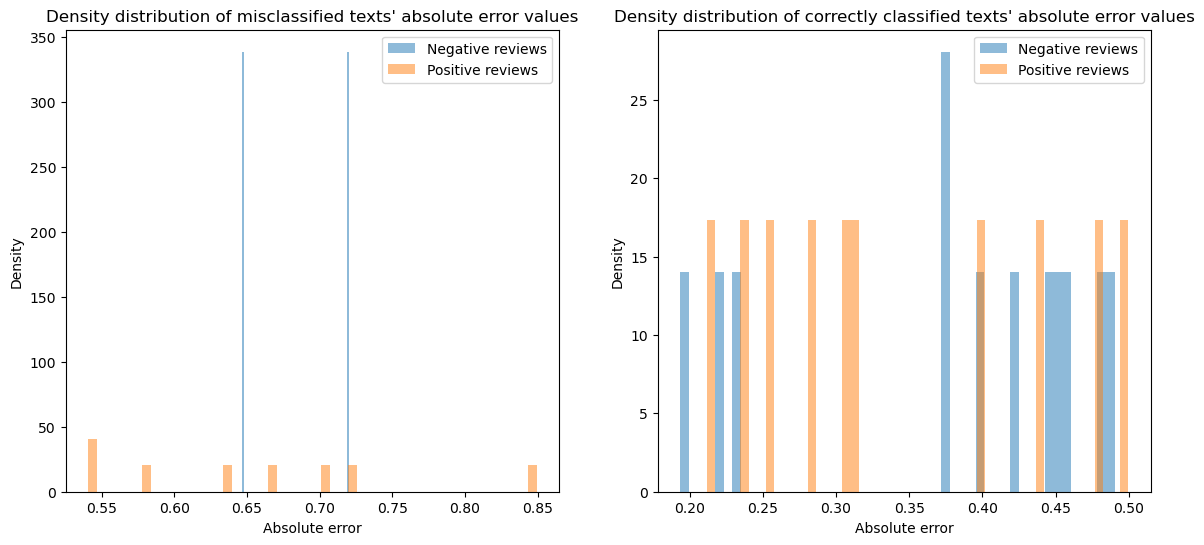

In [ ]:
plot_absolute_error(rf_df)

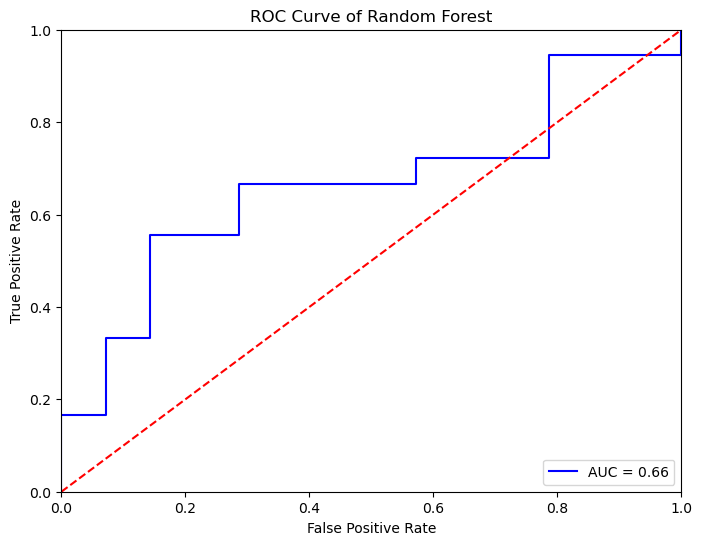

In [ ]:
rf_auc = plot_auc(test_df, rfmodel.predict_proba(X_test)[:,1], "Random Forest")

- **Logistic Regression**

In [ ]:
lr_df = error_analysis(test_df,
                       lr_prediction, 
                       prediction_prob=lrmodel.predict_proba(X_test)[:,1])

Distribution of misclassified texts:
 1    8
0    4
Name: Recommended, dtype: int64


The misclassification seems to appear more in **positive** reviews.

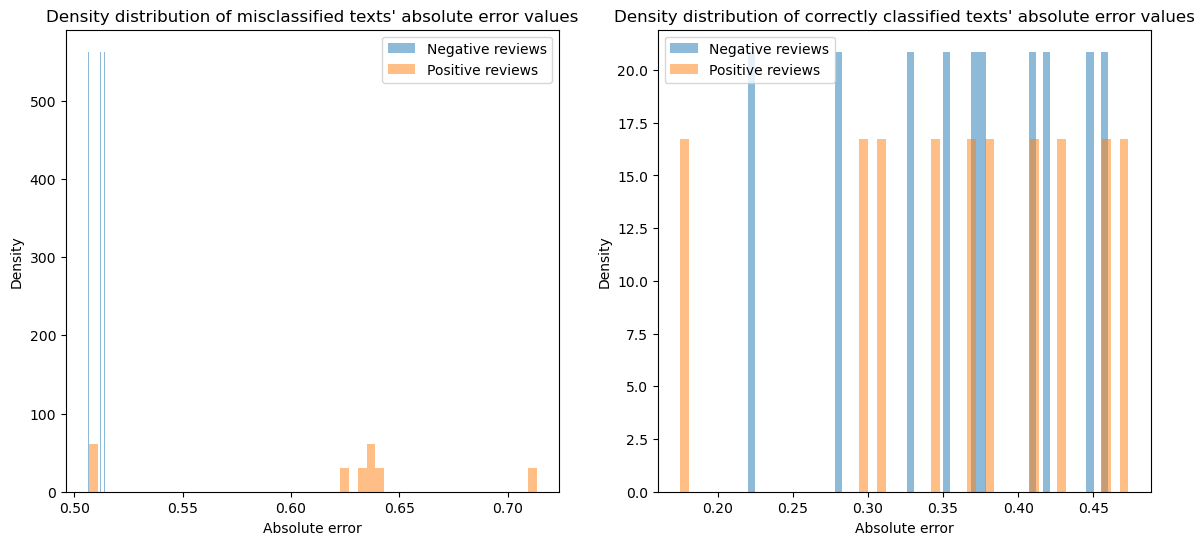

In [ ]:
plot_absolute_error(lr_df)

The absolute error values of negative reviews are relatively smaller than the ones of the positive reviews.

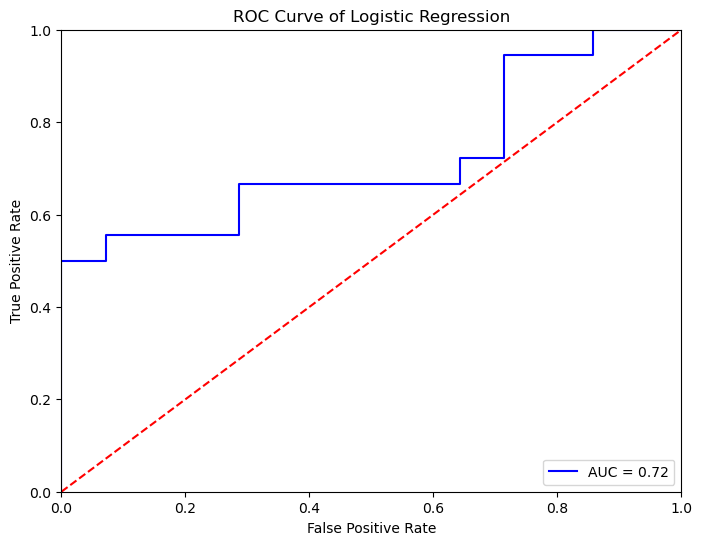

In [ ]:
lr_auc = plot_auc(test_df, lrmodel.predict_proba(X_test)[:,1], "Logistic Regression")

- **Gradient Boosting Classifier**

In [ ]:
gb_df = error_analysis(test_df,
                       gb_prediction, 
                       prediction_prob=gbmodel.predict_proba(X_test)[:,1])

Distribution of misclassified texts:
 1    9
0    4
Name: Recommended, dtype: int64


While the test data is balanced in terms of the types of labels, the misclassification of the Random Forest model seems to appear more in **positive** reviews.

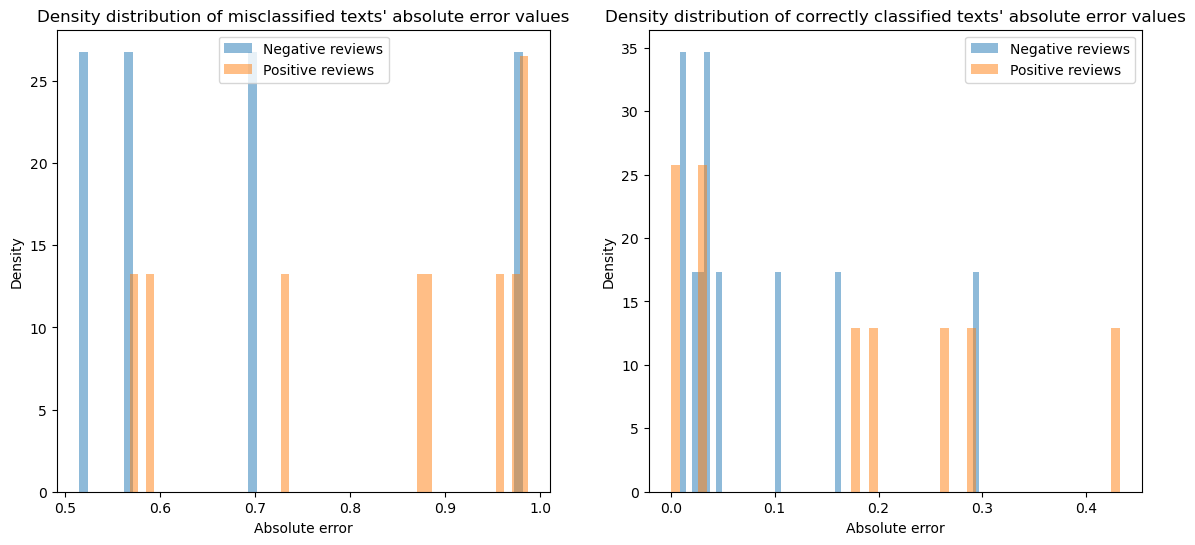

In [ ]:
plot_absolute_error(gb_df)

The absolute error values of negative reviews are relatively smaller than the ones of the positive reviews.

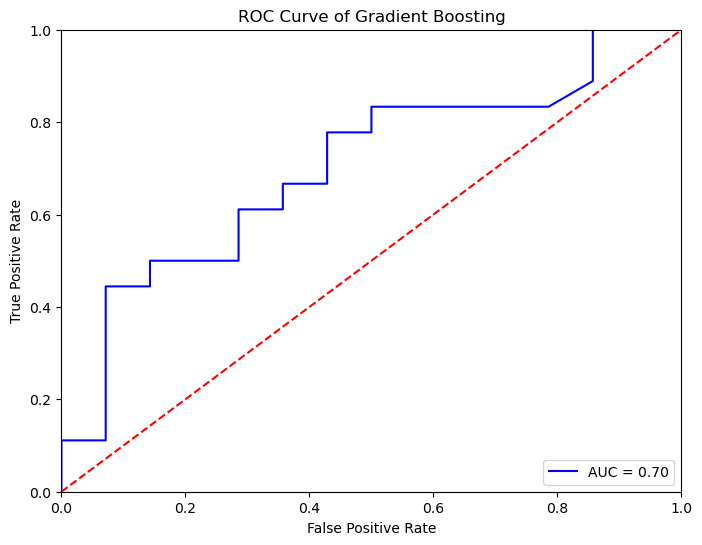

In [ ]:
gb_auc = plot_auc(test_df, gbmodel.predict_proba(X_test)[:,1], "Gradient Boosting")

- **Multi-layer Perceptron Classifier**

In [ ]:
nn_df = error_analysis(test_df,
                       nn_prediction, 
                       prediction_prob=nnmodel.predict_proba(X_test)[:,1])

Distribution of misclassified texts:
 1    7
Name: Recommended, dtype: int64


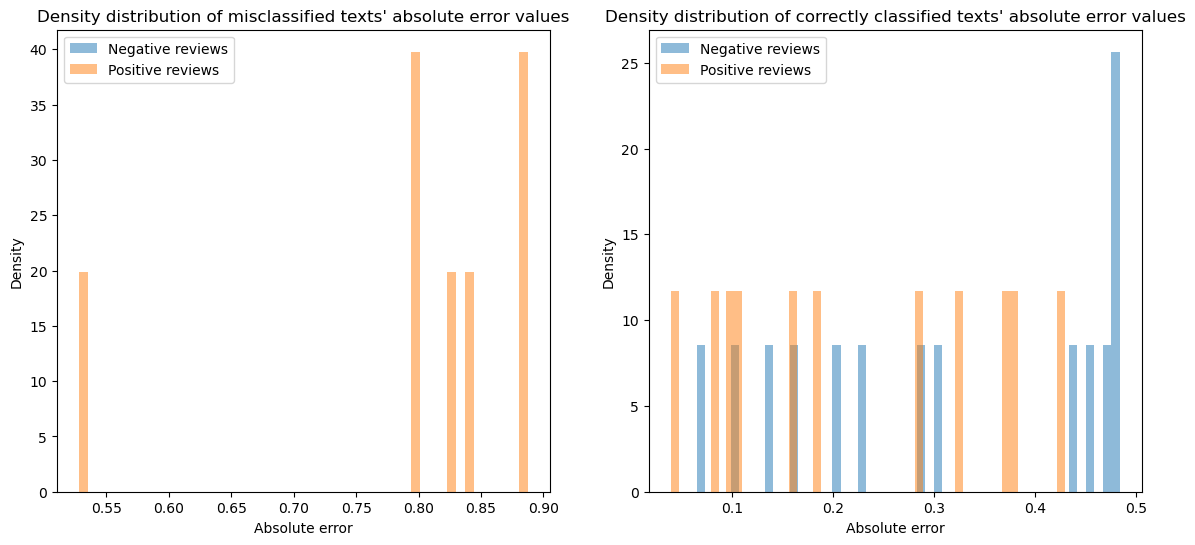

In [ ]:
plot_absolute_error(nn_df)

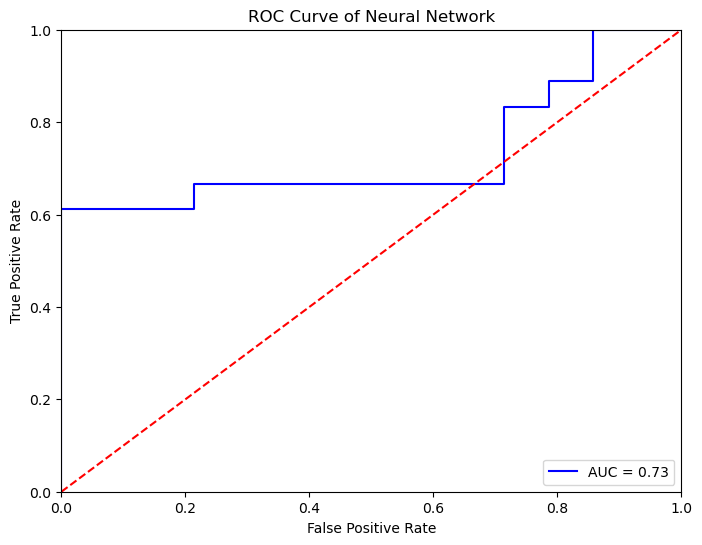

In [ ]:
nn_auc = plot_auc(test_df, nnmodel.predict_proba(X_test)[:,1], "Neural Network")

### 2.1.4 Save model results <a class="anchor" id="chapter2.1.4"></a>

In [ ]:
rf_accuracy = accuracy_score(test_df.Recommended.values, rf_prediction)
summary_df = summary_df.append({'Model': 'Random Forest (TF-IDF)', 
                                'Accuracy': rf_accuracy,
                                'AUC': rf_auc}, ignore_index=True)

In [ ]:
lr_accuracy = accuracy_score(test_df.Recommended.values, lr_prediction)
summary_df = summary_df.append({'Model': 'Logistic Regression (TF-IDF)', 
                                'Accuracy': lr_accuracy,
                                'AUC': lr_auc}, ignore_index=True)

In [ ]:
svc_accuracy = accuracy_score(test_df.Recommended.values, svc_prediction)
summary_df = summary_df.append({'Model': 'Support Vector Classifier (TF-IDF)', 
                                'Accuracy': svc_accuracy,
                                'AUC': np.nan}, ignore_index=True)

In [ ]:
gb_accuracy = accuracy_score(test_df.Recommended.values, gb_prediction)
summary_df = summary_df.append({'Model': 'Gradient Boosting Classifier (TF-IDF)', 
                                'Accuracy': gb_accuracy,
                                'AUC': gb_auc}, ignore_index=True)

In [ ]:
nn_accuracy = accuracy_score(test_df.Recommended.values, nn_prediction)
summary_df = summary_df.append({'Model': 'Neural Network Classifier (TF-IDF)', 
                                'Accuracy': nn_accuracy,
                                'AUC': nn_auc}, ignore_index=True)

<hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr>

## <p style="text-align: center;">2.2 LSTM <a class="anchor" id="chapter2.2"></a><hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr></p>

**Helper function**

In [ ]:
def plot_history(history):
    '''
    This function returns two subplots that show the compiling history of the neural network
    
    parameter:
        history (keras.callbacks.History): compiling history of the trained model
            
    returns:
        Two line subplots
    '''
    plt.rcParams["figure.figsize"] = (14,6)
    fig, ax = plt.subplots(1, 2)
    
    # Plot changes in loss values
    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    epochs = range(1, len(loss_values)+1)

    ax[0].plot(epochs, loss_values, label='Training Loss')
    ax[0].plot(epochs, val_loss_values, label='Validation Loss')
    ax[0].legend()
    ax[0].set_title('Compiling history of model')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    
    # Plot changes in loss values
    acc_values = history.history['accuracy']
    val_acc_values = history.history['val_accuracy']
    epochs = range(1, len(acc_values)+1)

    ax[1].plot(epochs, acc_values, label='Training Accuracy')
    ax[1].plot(epochs, val_acc_values, label='Validation Accuracy')
    ax[1].legend()
    ax[1].set_title('Compiling history of model')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    
    plt.show()

### 2.2.1 Preprocessing <a class="anchor" id="chapter2.2.1"></a>

- Remove stopwords

In [ ]:
# Remove stopwords using gensim
train_txt = train_df.Review.values.tolist()
test_txt = test_df.Review.values.tolist()

- Tokenization

In [ ]:
# # Tokenization
train_tokenized = [simple_preprocess(text) for text in train_txt]
test_tokenized = [simple_preprocess(text) for text in test_txt]

- Remove infrequent words

In [ ]:
# Remove infrequent (frequency<50) words in train dataset
frequency = defaultdict(int)
for text in train_tokenized:
    for token in text:
        frequency[token] += 1

train_texts = [
    [token for token in text]
    for text in train_tokenized
]

# Remove infrequent (frequency<50) words in test dataset
frequency2 = defaultdict(int)
for text in test_tokenized:
    for token in text:
        frequency2[token] += 1

test_texts = [
    [token for token in text]
    for text in test_tokenized
]

all_texts = train_texts + test_texts

In [ ]:
# Create an instance object of the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)

total_words = len(tokenizer.word_index)

In [ ]:
# Iterate through the list of comments; For each text, use the tokenizer
# to encode it into a sequence of numbers (word indices)
input_sequences = [tokenizer.texts_to_sequences([line])[0] for line in all_texts]

# Determine the largest length of all texts
max_sequence_len = max([len(x) for x in input_sequences]) 
print('The longest text has %d words' %max_sequence_len)

The longest text has 240 words


In [ ]:
# Redefine max_sequence_len
max_sequence_len = 240

# Pad sequences
input_sequences = np.array(pad_sequences(input_sequences, 
                                         maxlen=max_sequence_len, 
                                         padding='post'))

print('Shape of the preprocessed sequences (combining both train and test):', 
      np.shape(input_sequences))

Shape of the preprocessed sequences (combining both train and test): (128, 240)


In [ ]:
X_train = input_sequences[:96]
X_test = input_sequences[96:]

y_train = train_df.Recommended.values
y_test = test_df.Recommended.values

### 2.2.2 Initial modelling <a class="anchor" id="chapter2.2.2"></a>

In [ ]:
lstm_size = 80
embedding_size = 80
dropout_rate = 0.4

EPOCHS = 50
BATCH_SIZE = 5

In [ ]:
tf.compat.v1.reset_default_graph()
clear_session()

input_layer = Input(shape=(max_sequence_len))

# The embedding layer here converts the words into vectors.
# Here, since the comments have ben padded, the total
# "vocabulary size" will be the number of words plus 1 (the
# additional "word" is the 0's used in padding). Also due to
# the padding, the mask_zero parameter should be set as True.
embed_layer = Embedding(input_dim=total_words+1,
                        output_dim=embedding_size, 
                        input_length=max_sequence_len,
                        mask_zero=True)(input_layer)

lstm_layer1 = LSTM(lstm_size, return_sequences=True)(embed_layer)
dropout_layer = Dropout(dropout_rate)(lstm_layer1)
lstm_layer2 = LSTM(lstm_size)(dropout_layer)

# Since we need to output a probability (of the text being positive)
# which is between 0 and 1
output = Dense(1, activation='sigmoid')(lstm_layer2)

lstm_1 = Model(inputs=input_layer, outputs=output)
lstm_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240)]             0         
                                                                 
 embedding (Embedding)       (None, 240, 80)           160080    
                                                                 
 lstm (LSTM)                 (None, 240, 80)           51520     
                                                                 
 dropout (Dropout)           (None, 240, 80)           0         
                                                                 
 lstm_1 (LSTM)               (None, 80)                51520     
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 263,201
Trainable params: 263,201
Non-trainable

In [ ]:
# Loss (since it's a binary classification problem)
loss = losses.BinaryCrossentropy()

# Optimizer
optimizer = Adam(learning_rate=0.00025)

# Compilation
lstm_1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', 
                   verbose=1, patience=5)

lstm_history1 = lstm_1.fit(X_train, y_train,
                           validation_split=0.25,
                           epochs=EPOCHS,
                           batch_size=BATCH_SIZE,
                           callbacks=es)

Epoch 1/50
15/15 [==============================] - 40s 1s/step - loss: 0.6936 - accuracy: 0.5278 - val_loss: 0.6911 - val_accuracy: 0.5833
Epoch 2/50
15/15 [==============================] - 12s 808ms/step - loss: 0.6911 - accuracy: 0.5278 - val_loss: 0.6901 - val_accuracy: 0.5833
Epoch 3/50
15/15 [==============================] - 12s 807ms/step - loss: 0.6881 - accuracy: 0.5278 - val_loss: 0.6865 - val_accuracy: 0.5833
Epoch 4/50
15/15 [==============================] - 12s 800ms/step - loss: 0.6750 - accuracy: 0.5278 - val_loss: 0.6746 - val_accuracy: 0.5833
Epoch 5/50
15/15 [==============================] - 12s 803ms/step - loss: 0.5814 - accuracy: 0.6667 - val_loss: 0.5767 - val_accuracy: 0.7917
Epoch 6/50
15/15 [==============================] - 12s 805ms/step - loss: 0.4563 - accuracy: 1.0000 - val_loss: 0.5534 - val_accuracy: 0.7083
Epoch 7/50
15/15 [==============================] - 12s 789ms/step - loss: 0.2354 - accuracy: 0.9861 - val_loss: 0.9305 - val_accuracy: 0.6667
Ep

In [ ]:
lstm_prediction1 = lstm_1.predict(X_test)
lstm_prediction1 = [1 if p>0.5 else 0 for p in lstm_prediction1]

print(classification_report(test_df.Recommended.values, lstm_prediction1))

              precision    recall  f1-score   support

           0       0.62      0.71      0.67        14
           1       0.75      0.67      0.71        18

    accuracy                           0.69        32
   macro avg       0.69      0.69      0.69        32
weighted avg       0.70      0.69      0.69        32



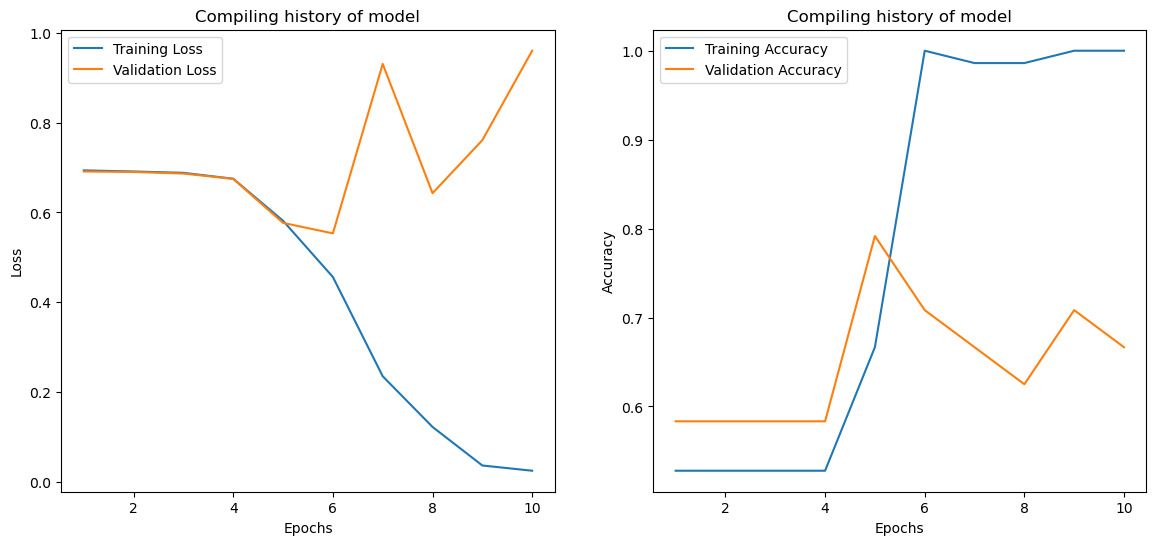

In [ ]:
plot_history(lstm_history1)

### 2.2.3 Bidirectional LSTM modelling <a class="anchor" id="chapter2.2.2"></a>

In [ ]:
lstm_size = 80
embedding_size = 80
dropout_rate = 0.6

EPOCHS = 50
BATCH_SIZE = 5

In [ ]:
tf.compat.v1.reset_default_graph()
clear_session()

input_layer = Input(shape=(max_sequence_len))

# The embedding layer here converts the words into vectors.
# Here, since the comments have ben padded, the total
# "vocabulary size" will be the number of words plus 1 (the
# additional "word" is the 0's used in padding). Also due to
# the padding, the mask_zero parameter should be set as True.
embed_layer = Embedding(input_dim=total_words+1,
                        output_dim=embedding_size, 
                        input_length=max_sequence_len,
                        mask_zero=True)(input_layer)

lstm_layer1 = Bidirectional(LSTM(lstm_size, return_sequences=True))(embed_layer)
dropout_layer = Dropout(dropout_rate)(lstm_layer1)
lstm_layer2 = Bidirectional(LSTM(lstm_size))(dropout_layer)

# Since we need to output a probability (of the text being positive)
# which is between 0 and 1
output = Dense(1, activation='sigmoid')(lstm_layer2)

lstm_3 = Model(inputs=input_layer, outputs=output)
lstm_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240)]             0         
                                                                 
 embedding (Embedding)       (None, 240, 80)           160080    
                                                                 
 bidirectional (Bidirectiona  (None, 240, 160)         103040    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 240, 160)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 160)              154240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 161   

In [ ]:
# Loss (since it's a binary classification problem)
loss = losses.BinaryCrossentropy()

# Optimizer
optimizer = Adam(learning_rate=0.0001)

# Compilation
lstm_3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', 
                   verbose=1, patience=5)

lstm_history3 = lstm_3.fit(X_train, y_train,
                           validation_split=0.25,
                           epochs=EPOCHS,
                           batch_size=BATCH_SIZE,
                           callbacks=es)

Epoch 1/50
15/15 [==============================] - 44s 2s/step - loss: 0.6931 - accuracy: 0.5417 - val_loss: 0.6924 - val_accuracy: 0.6250
Epoch 2/50
15/15 [==============================] - 20s 1s/step - loss: 0.6919 - accuracy: 0.6389 - val_loss: 0.6916 - val_accuracy: 0.7917
Epoch 3/50
15/15 [==============================] - 20s 1s/step - loss: 0.6903 - accuracy: 0.7778 - val_loss: 0.6913 - val_accuracy: 0.7917
Epoch 4/50
15/15 [==============================] - 20s 1s/step - loss: 0.6880 - accuracy: 0.8889 - val_loss: 0.6905 - val_accuracy: 0.7917
Epoch 5/50
15/15 [==============================] - 20s 1s/step - loss: 0.6850 - accuracy: 0.8333 - val_loss: 0.6886 - val_accuracy: 0.6667
Epoch 6/50
15/15 [==============================] - 20s 1s/step - loss: 0.6816 - accuracy: 0.8194 - val_loss: 0.6875 - val_accuracy: 0.8333
Epoch 7/50
15/15 [==============================] - 20s 1s/step - loss: 0.6744 - accuracy: 0.7361 - val_loss: 0.6820 - val_accuracy: 0.5833
Epoch 8/50
15/15 [==

In [ ]:
lstm_prediction3 = lstm_3.predict(X_test)
lstm_prediction3 = [1 if p>0.5 else 0 for p in lstm_prediction3]

print(classification_report(test_df.Recommended.values, lstm_prediction3))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        14
           1       0.78      0.78      0.78        18

    accuracy                           0.75        32
   macro avg       0.75      0.75      0.75        32
weighted avg       0.75      0.75      0.75        32



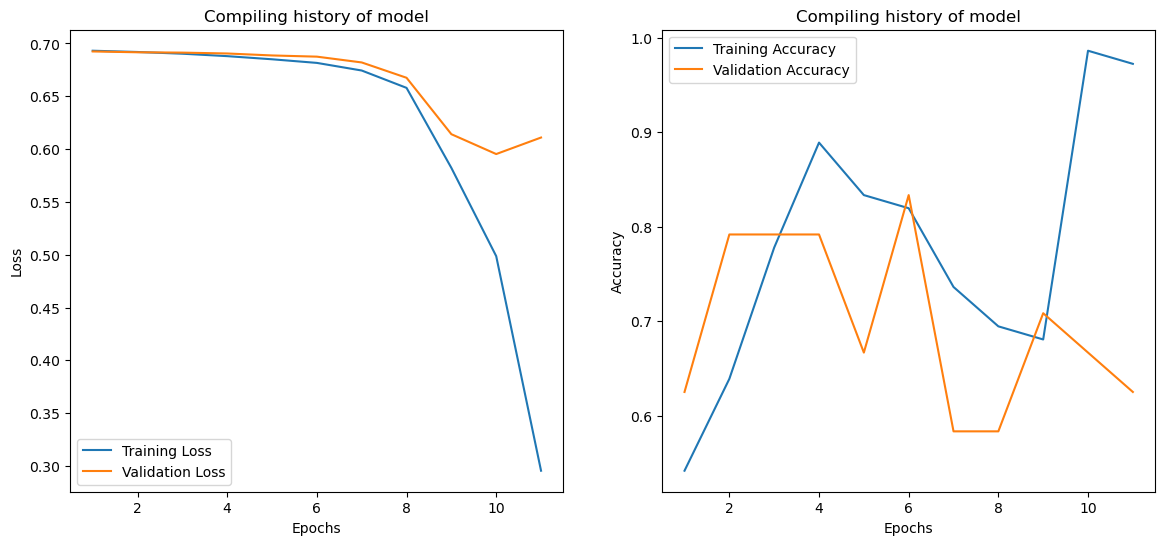

In [ ]:
plot_history(lstm_history3)

### 2.2.3 LSTM with GloVe <a class="anchor" id="chapter2.2.3"></a>

In [ ]:
# Extract the embeddings from GloVe
with open('glove.6B.50d.txt', 'r', encoding='UTF-8') as f:
    word_to_vec_map = {}
    for line in f:
        w_line = line.split()
        curr_word = w_line[0]
        word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)

# Size of the GloVe embeddings
embedding_dim = len(word_to_vec_map['the'])

In [ ]:
words_to_index = tokenizer.word_index
emb_matrix = np.zeros((total_words+1, embedding_dim))

# Create an embedding matrix based on the unique words in all comments (which is
# stored in the words_to_index variable) and the embeddings provided by the GloVe
# file above
for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index] = embedding_vector

del word_to_vec_map

In [ ]:
lstm_size = 100
dropout_rate = 0.2

EPOCHS = 20
BATCH_SIZE = 10

In [ ]:
tf.compat.v1.reset_default_graph()
clear_session()

input_layer = Input(shape=(max_sequence_len))

# Create an embedding layer using the embedding matrix defined above
# Note: since the GloVe embeddings have already been pretrained, the
# trainable parameter here will be False
embed_layer = Embedding(input_dim=total_words+1,
                        output_dim=embedding_dim,
                        input_length=max_sequence_len,
                        weights = [emb_matrix],
                        trainable=False)(input_layer)

lstm_layer1 = Bidirectional(LSTM(lstm_size, return_sequences=True))(embed_layer)
dropout_layer_1 = Dropout(dropout_rate)(lstm_layer1)

lstm_layer2 = Bidirectional(LSTM(lstm_size, return_sequences=False))(dropout_layer_1)
dropout_layer2 = Dropout(dropout_rate)(lstm_layer2)

output = Dense(1, activation='sigmoid')(dropout_layer2)

lstm_2 = Model(inputs=input_layer, outputs=output)
lstm_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240)]             0         
                                                                 
 embedding (Embedding)       (None, 240, 50)           100050    
                                                                 
 bidirectional (Bidirectiona  (None, 240, 200)         120800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 240, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 200)               0     

In [ ]:
# Loss
loss = losses.BinaryCrossentropy()

# Optimizer
optimizer = Adam(learning_rate=0.00025)

# Compilation
lstm_2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', 
                   verbose=1, patience=5)

lstm_history2 = lstm_2.fit(X_train, y_train,
                           validation_split=0.25,
                           epochs=EPOCHS,
                           batch_size=BATCH_SIZE,
                           callbacks=es)

Epoch 1/50
8/8 [==============================] - 34s 3s/step - loss: 0.6962 - accuracy: 0.4583 - val_loss: 0.6976 - val_accuracy: 0.3750
Epoch 2/50
8/8 [==============================] - 20s 3s/step - loss: 0.6863 - accuracy: 0.5694 - val_loss: 0.6778 - val_accuracy: 0.5833
Epoch 3/50
8/8 [==============================] - 21s 3s/step - loss: 0.6775 - accuracy: 0.5278 - val_loss: 0.6728 - val_accuracy: 0.5833
Epoch 4/50
8/8 [==============================] - 21s 3s/step - loss: 0.6673 - accuracy: 0.5694 - val_loss: 0.6773 - val_accuracy: 0.5417
Epoch 5/50
8/8 [==============================] - 21s 3s/step - loss: 0.6481 - accuracy: 0.7083 - val_loss: 0.6852 - val_accuracy: 0.4583
Epoch 6/50
8/8 [==============================] - 21s 3s/step - loss: 0.6352 - accuracy: 0.7222 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 7/50
8/8 [==============================] - 21s 3s/step - loss: 0.6141 - accuracy: 0.6806 - val_loss: 0.6642 - val_accuracy: 0.5417
Epoch 00007: early stopping


In [ ]:
lstm_prediction2 = lstm_2.predict(X_test)
lstm_prediction2 = [1 if p>0.5 else 0 for p in lstm_prediction2]
print(classification_report(y_test, lstm_prediction2))

              precision    recall  f1-score   support

           0       0.41      0.50      0.45        14
           1       0.53      0.44      0.48        18

    accuracy                           0.47        32
   macro avg       0.47      0.47      0.47        32
weighted avg       0.48      0.47      0.47        32



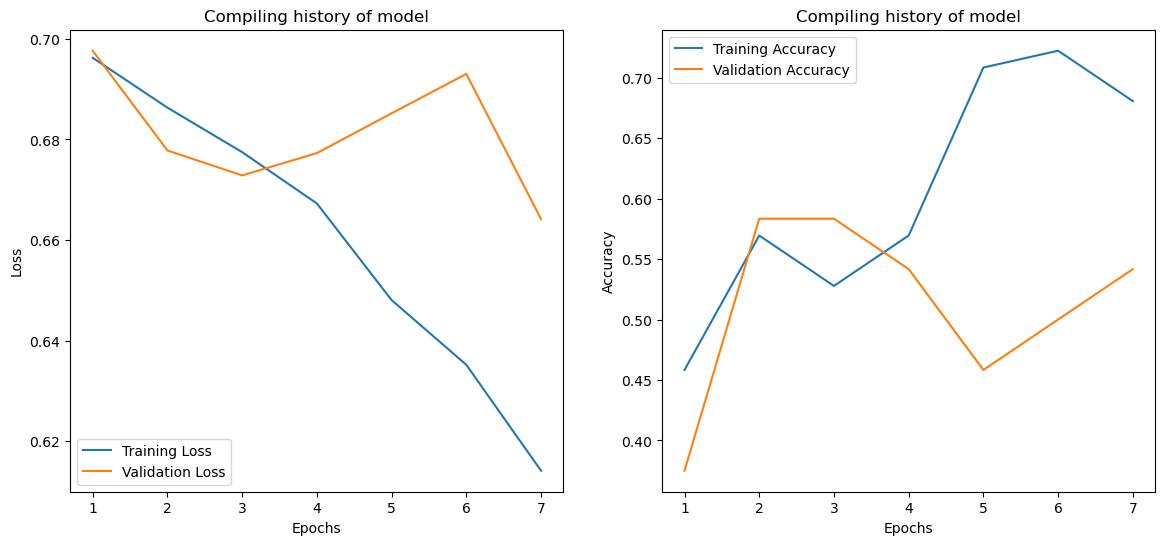

In [ ]:
plot_history(lstm_history2)

### 2.2.4 Error analysis <a class="anchor" id="chapter2.2.4"></a>

- **LSTM (Plain)**

In [ ]:
lstm_df1 = error_analysis(test_df,
                          lstm_prediction1, 
                          prediction_prob=lstm_1.predict(X_test))

Distribution of misclassified texts:
 1    6
0    4
Name: Recommended, dtype: int64


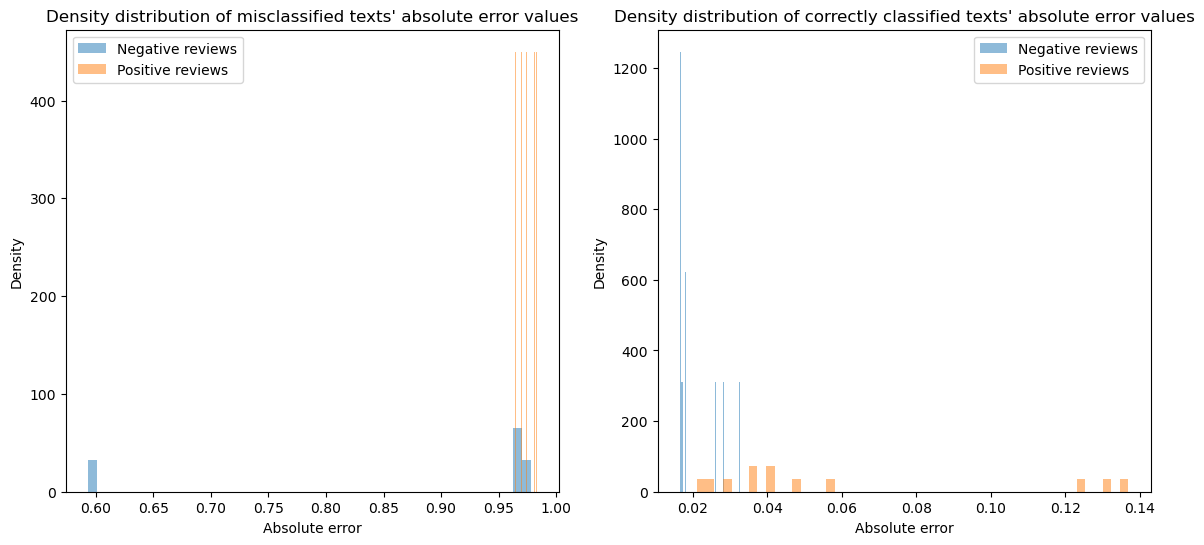

In [ ]:
plot_absolute_error(lstm_df1)

The predicted probabilities of the model are relatively extreme, resulting in very large absolute errors for misclassified samples and very small absolute errors for correctly classified texts.

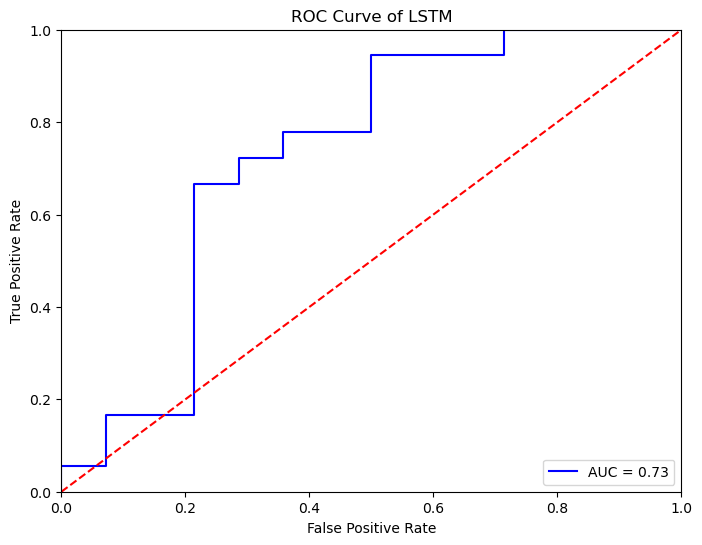

In [ ]:
lstm_auc1 = plot_auc(test_df, lstm_1.predict(X_test), "LSTM")

- **Bidirectional LSTM (Plain)**

In [ ]:
lstm_df3 = error_analysis(test_df,
                          lstm_prediction3, 
                          prediction_prob=lstm_3.predict(X_test))

Distribution of misclassified texts:
 0    4
1    4
Name: Recommended, dtype: int64


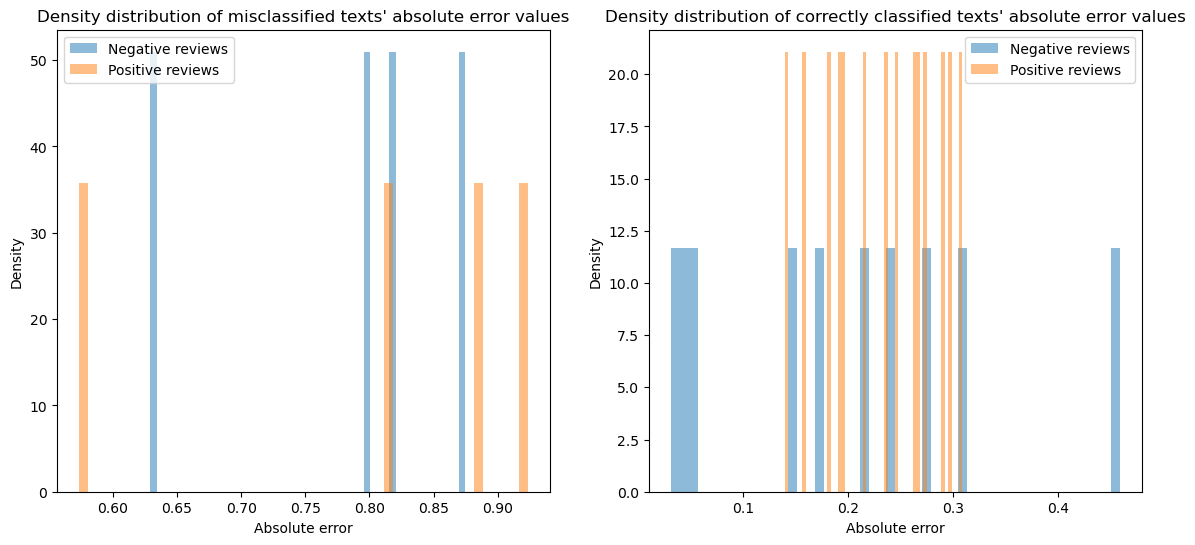

In [ ]:
plot_absolute_error(lstm_df3)

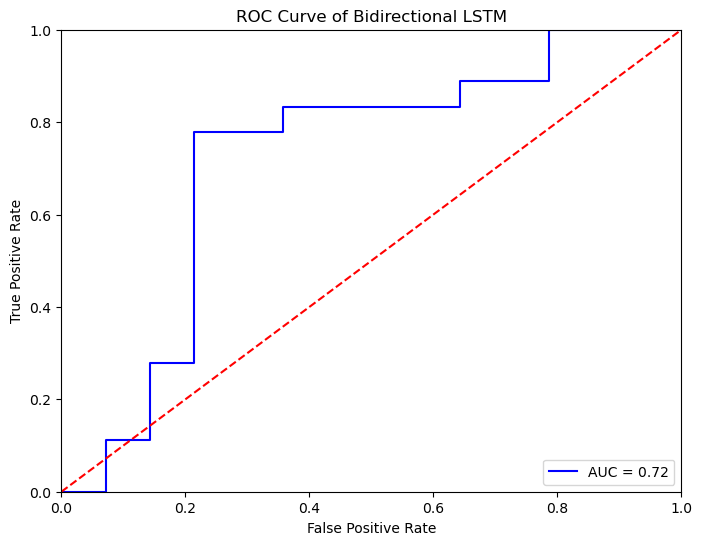

In [ ]:
lstm_auc3 = plot_auc(test_df, lstm_3.predict(X_test), "Bidirectional LSTM")

- **LSTM (with GloVe embedding)**

In [ ]:
lstm_df2 = error_analysis(test_df,
                          lstm_prediction2, 
                          prediction_prob=lstm_2.predict(X_test))

Distribution of misclassified texts:
 1    10
0     7
Name: Recommended, dtype: int64


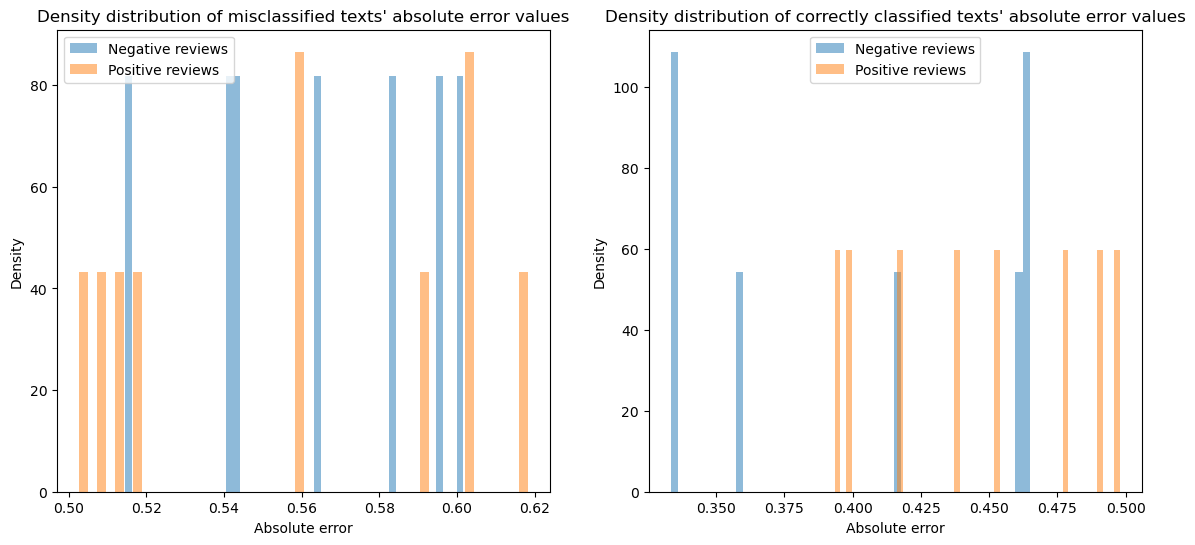

In [ ]:
plot_absolute_error(lstm_df2)

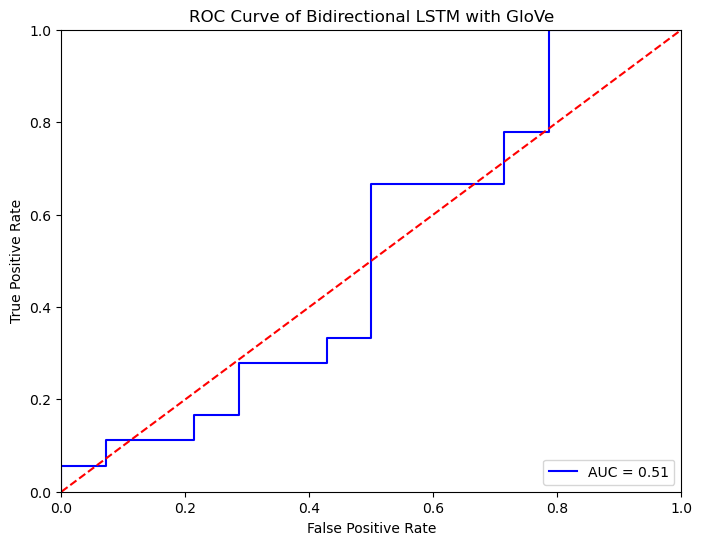

In [ ]:
lstm_auc2 = plot_auc(test_df, lstm_2.predict(X_test), "Bidirectional LSTM with GloVe")

Using pretrained word embedding vectors does not seem to improve the performance of the model.

### 2.2.5 Save model results <a class="anchor" id="chapter2.2.5"></a>

In [ ]:
lstm_accuracy1 = accuracy_score(test_df.Recommended.values, lstm_prediction1)
summary_df = summary_df.append({'Model': 'LSTM (Initial)', 
                                'Accuracy': lstm_accuracy1,
                                'AUC': lstm_auc1}, ignore_index=True)

In [ ]:
lstm_accuracy3 = accuracy_score(test_df.Recommended.values, lstm_prediction3)
summary_df = summary_df.append({'Model': 'Bidirectional LSTM (Initial)', 
                                'Accuracy': lstm_accuracy3,
                                'AUC': lstm_auc3}, ignore_index=True)

In [ ]:
lstm_accuracy2 = accuracy_score(test_df.Recommended.values, lstm_prediction2)
summary_df = summary_df.append({'Model': 'Bidirectional LSTM (GloVe embedding)', 
                                'Accuracy': lstm_accuracy2,
                                'AUC': lstm_auc2}, ignore_index=True)

<hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr>

## <p style="text-align: center;">2.3 fastText <a class="anchor" id="chapter2.3"></a><hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr></p>

### 2.3.1 Preprocessing <a class="anchor" id="chapter2.3.1"></a>

In [ ]:
train_copy = train_df.drop("Rating", axis=1)
test_copy = test_df.drop("Rating", axis=1)

train_copy['Review'] = train_copy.apply(lambda x: remove_stopwords(x.Review), axis=1)
test_copy['Review'] = test_copy.apply(lambda x: remove_stopwords(x.Review), axis=1)

train_copy.iloc[:, 0] = train_copy.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))
test_copy.iloc[:, 0] = test_copy.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))

# Prefixing each row of the category column with '__label__' (required format for the model)
train_copy.iloc[:, 1] = train_copy.iloc[:, 1].apply(lambda x: '__label__' + str(x))
test_copy.iloc[:, 1] = test_copy.iloc[:, 1].apply(lambda x: '__label__' + str(x))

In [ ]:
train_copy[['Review', 'Recommended']].to_csv('train.txt', 
                                           index=False, 
                                           sep = ' ',
                                           header = None, 
                                           quoting = csv.QUOTE_NONE, 
                                           quotechar = "", 
                                           escapechar = " ")

test_copy[['Review', 'Recommended']].to_csv('test.txt', 
                                           index=False, 
                                           sep = ' ',
                                           header = None, 
                                           quoting = csv.QUOTE_NONE, 
                                           quotechar = "", 
                                           escapechar = " ")

### 2.3.2 Model training <a class="anchor" id="chapter2.3.2"></a>

In [ ]:
fasttext_model = fasttext.train_supervised(input="train.txt", epoch=50, lr=0.0025, wordNgrams=5, dim=100)

# Predicted probability
fasttext_pred = fasttext_model.predict(test_copy.Review.tolist(), k=2)
fasttext_prob = []
for i in range(len(test_copy)):
    if fasttext_pred[0][i][0] == '__label__1':
        fasttext_prob.append(fasttext_pred[1][i][0])
    else:
        fasttext_prob.append(1-fasttext_pred[1][i][0])

# Predicted label
fasttext_label = [1 if p>0.5 else 0 for p in fasttext_prob]

In [ ]:
print(classification_report(test_df.Recommended.values, fasttext_label))

              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.85      0.65      0.73        17

    accuracy                           0.75        32
   macro avg       0.77      0.76      0.75        32
weighted avg       0.77      0.75      0.75        32



### 2.3.3 Error analysis <a class="anchor" id="chapter2.3.3"></a>

In [ ]:
fast_df = error_analysis(test_df,
                         fasttext_label, 
                         prediction_prob=fasttext_prob)

Distribution of misclassified texts:
 1    6
0    2
Name: Recommended, dtype: int64


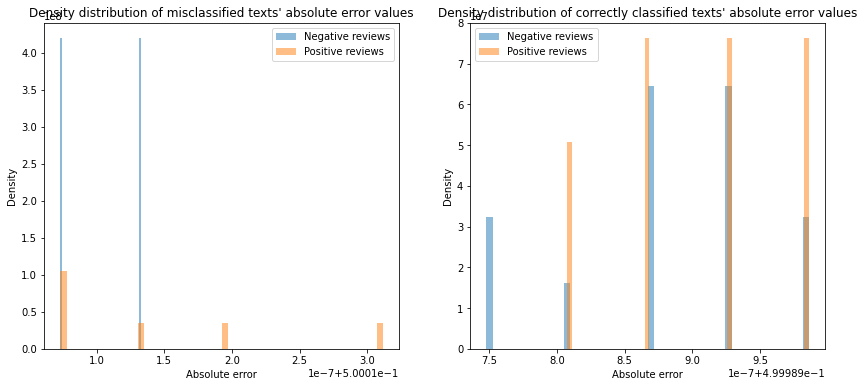

In [ ]:
plot_absolute_error(fast_df)

Predicted values of the fasttext model are very close to 0.5.

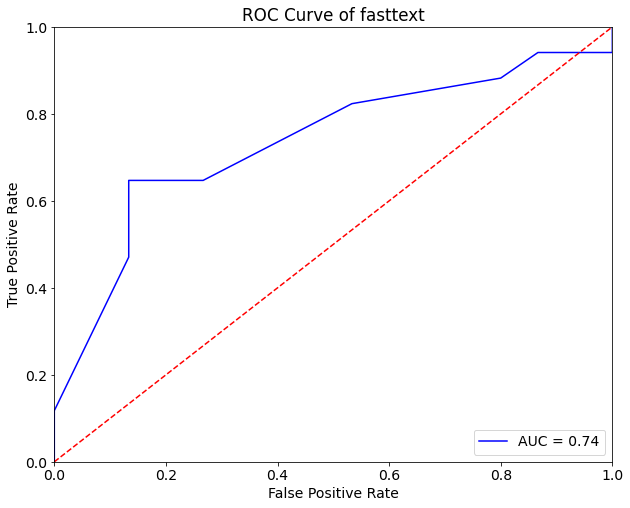

In [ ]:
fasttext_auc = plot_auc(test_df, fasttext_prob, "fasttext")

### 2.3.4 Save model results <a class="anchor" id="chapter2.3.4"></a>

In [ ]:
fasttext_acc = accuracy_score(test_df.Recommended.values, fasttext_label)
summary_df = summary_df.append({'Model': 'fastText', 
                                'Accuracy': fasttext_acc,
                                'AUC': fasttext_auc}, ignore_index=True)

<hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr>

## <p style="text-align: center;">2.4 BERT <a class="anchor" id="chapter2.4"></a><hr style="height:4px; border-top: 1px; display: block; background-color: lightsalmon"> </hr></p>

### 2.4.1 Preprocessing <a class="anchor" id="chapter2.4.1"></a>

In [ ]:
max_len = 240
batch_size = 5

In [ ]:
# Transformer Model
bert = ktrain.text.Transformer('bert-base-uncased', maxlen=max_len, classes = [0,1])

X_train = train_df['Review'].tolist()
y_train = train_df['Recommended'].tolist()

X_test = test_df['Review'].tolist()
y_test = test_df['Recommended'].tolist()

# Pre-processing training & test data
train = bert.preprocess_train(X_train,y_train)
test = bert.preprocess_test(X_test,y_test)

model = bert.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=test, batch_size=batch_size)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 104
	95percentile : 196
	99percentile : 213


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 94
	95percentile : 191
	99percentile : 205


Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

### 2.4.2 Find the suitable range of learning rates <a class="anchor" id="chapter2.4.2"></a>

simulating training for different learning rates... this may take a few moments...
Epoch 1/10
19/19 [==============================] - 280s 13s/step - loss: 0.7241 - accuracy: 0.4632
Epoch 2/10
19/19 [==============================] - 233s 13s/step - loss: 0.7232 - accuracy: 0.4286
Epoch 3/10
19/19 [==============================] - 252s 13s/step - loss: 0.6503 - accuracy: 0.5824
Epoch 4/10
19/19 [==============================] - 238s 12s/step - loss: 0.6744 - accuracy: 0.5824
Epoch 5/10
19/19 [==============================] - 233s 12s/step - loss: 0.7149 - accuracy: 0.5055
Epoch 6/10
19/19 [==============================] - 230s 12s/step - loss: 0.8786 - accuracy: 0.5604
Epoch 7/10
19/19 [==============================] - 236s 12s/step - loss: 2.8948 - accuracy: 0.4945
Epoch 8/10
19/19 [==============================] - 133s 7s/step - loss: 11.5863 - accuracy: 0.5686


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal lea

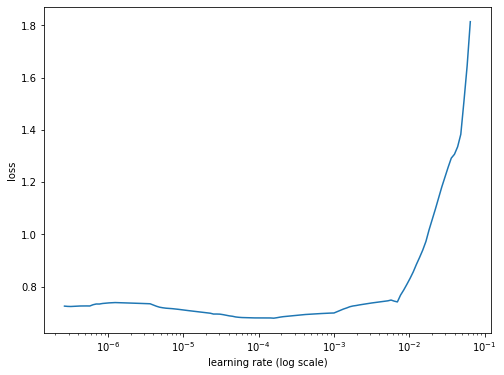

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)

learner.lr_find(max_epochs=10)
learner.lr_plot()

The plot above suggests that setting the learning rate in the range between 3e-4 and 1e-4 would be better since it has the lowest loss.

### 2.4.3 Model training <a class="anchor" id="chapter2.4.3"></a>

In [ ]:
learning_rate = 1e-4
epochs = 8
learner.fit_onecycle(learning_rate, epochs)

# Results summary
x = learner.validate(class_names=bert.get_classes())



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/8
20/20 [==============================] - 321s 15s/step - loss: 0.6677 - accuracy: 0.5625 - val_loss: 0.6438 - val_accuracy: 0.6875
Epoch 2/8
20/20 [==============================] - 282s 14s/step - loss: 0.5059 - accuracy: 0.7812 - val_loss: 0.5593 - val_accuracy: 0.6250
Epoch 3/8
20/20 [==============================] - 286s 14s/step - loss: 0.2794 - accuracy: 0.9167 - val_loss: 1.2063 - val_accuracy: 0.5000
Epoch 4/8
20/20 [==============================] - 291s 14s/step - loss: 0.4852 - accuracy: 0.7917 - val_loss: 0.6880 - val_accuracy: 0.6875
Epoch 5/8
20/20 [==============================] - 288s 14s/step - loss: 0.1622 - accuracy: 0.9479 - val_loss: 0.9358 - val_accuracy: 0.7188
Epoch 6/8
20/20 [==============================] - 291s 15s/step - loss: 0.0613 - accuracy: 0.9896 - val_loss: 0.9971 - val_accuracy: 0.6875
Epoch 7/8
20/20 [==============================] - 282s 14s/step - loss: 0.0684 - accuracy

### 2.4.4 Error analysis <a class="anchor" id="chapter2.4.4"></a>

In [ ]:
bert_df = error_analysis(test_df,
                         bert_label, 
                         prediction_prob=bert_prob)

Distribution of misclassified texts:
 1    5
0    4
Name: Recommended, dtype: int64


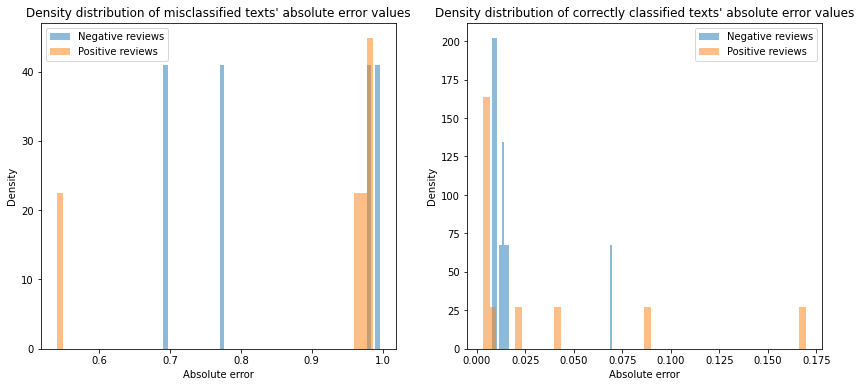

In [ ]:
plot_absolute_error(bert_df)

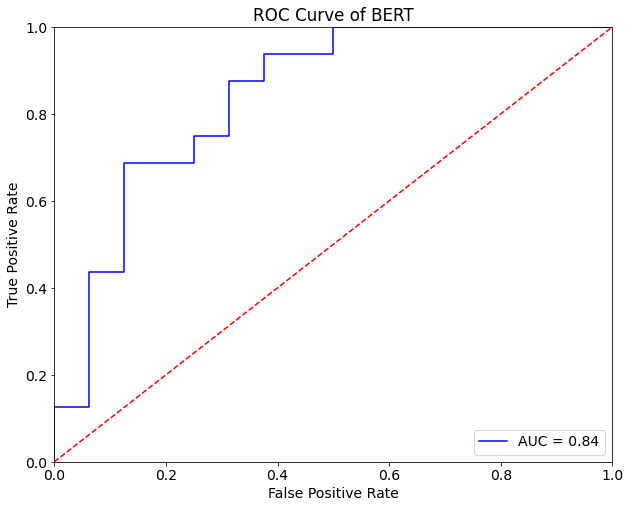

In [ ]:
bert_auc = plot_auc(test_df, bert_prob, "BERT")

### 2.4.5 Save model results <a class="anchor" id="chapter2.4.5"></a>

In [ ]:
# Model predictions
bert_pred = learner.predict(test)
bert_prob = [p[1] for p in bert_pred]
bert_label = [1 if p>0.5 else 0 for p in bert_prob]

In [ ]:
bert_accuracy = accuracy_score(test_df.Recommended.values, bert_label)
summary_df = summary_df.append({'Model': 'BERT', 
                                'Accuracy': bert_accuracy,
                                'AUC': bert_auc}, ignore_index=True)

print(classification_report(test_df.Recommended.values, bert_label))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73        16
           1       0.73      0.69      0.71        16

    accuracy                           0.72        32
   macro avg       0.72      0.72      0.72        32
weighted avg       0.72      0.72      0.72        32



# 3. Summary <a class="anchor" id="chapter3"></a>

## 3.1 Analysis of accuracy scores <a class="anchor" id="chapter3.1"></a>

In [ ]:
display(summary_df.sort_values('Accuracy', ascending=False))

,Model,Accuracy,AUC
4,Neural Network Classifier (TF-IDF),0.78125,0.730159
2,Support Vector Classifier (TF-IDF),0.75000,NaN
6,Bidirectional LSTM (Initial),0.75000,0.718254
8,fastText,0.75000,0.735294
9,BERT,0.71875,0.839844
0,Random Forest (TF-IDF),0.68750,0.662698
5,LSTM (Initial),0.68750,0.726190
1,Logistic Regression (TF-IDF),0.62500,0.722222
3,Gradient Boosting Classifier (TF-IDF),0.59375,0.700397
7,Bidirectional LSTM (GloVe embedding),0.46875,0.507937


In [ ]:
summary_df.to_csv("Binary_classification_summary.csv", index=False)

In [ ]:
summary_df['Avg_perf'] = summary_df.mean(axis=1)
display(summary_df.sort_values("Avg_perf", ascending=False))

,Model,Accuracy,AUC,Avg_perf
9,BERT,0.71875,0.839844,0.779297
4,Neural Network Classifier (TF-IDF),0.78125,0.730159,0.755704
2,Support Vector Classifier (TF-IDF),0.75000,NaN,0.750000
8,fastText,0.75000,0.735294,0.742647
6,Bidirectional LSTM (Initial),0.75000,0.718254,0.734127
5,LSTM (Initial),0.68750,0.726190,0.706845
0,Random Forest (TF-IDF),0.68750,0.662698,0.675099
1,Logistic Regression (TF-IDF),0.62500,0.722222,0.673611
3,Gradient Boosting Classifier (TF-IDF),0.59375,0.700397,0.647073
7,Bidirectional LSTM (GloVe embedding),0.46875,0.507937,0.488343


**<font color=dodgerblue>Analysis:</font>**

<font color=dodgerblue>1. Based on the summary table above, Neural Network Classifier has the highest overall accuracy (78%), and BERT has the highest AUC value (0.84).<br><br/>
    2. When averaging the accuracy and AUC values of each model, **BERT appears to outperform other models** with an accuracy score on validation data of 92.3%, which is not surprising given that the model is much more complex and that it has already been pre-trained.<br><br/>
    3. The performance of the fastText model and two of the TF-IDF models are very close to each other. This could be because **both types of models have used Bag of Words**.<br><br/>
    4. While TF-IDF models are the simplest ones among all, they have shown very good performance, especially using Multi-layer Perceptron classifier and Support Vector Classifier, which has a better performance when compared to LSTMs.<br><br/>
This can be partly explained by the structure of the models. Since the goal is to classify sentiment, the sentence structure itself does not matter. Instead of focusing on analysing the sentences themselves, **often times the specific words and their frequency used in the comments can tell much more about the sentiment**. With the TF-IDF matrices as training data, which is created by summarizing all the words' occurence within and across different texts, even a relatively simple model can learn from the somehow explicit relationship between the texts' sentiments and certain words' occurrence frequency and therefore achieve such high accuracy. For example, the model might learn that when the second word in the dictionary has a high score assigned by TF-IDF, the text is mostly positive.<br><br/>
    In comparison, **the LSTM models focuses more on the sequence of the texts themselves**. Even though the models also use an embedding layer that represents words with vectors and therefore also enables the models to learn the relationship between the words and the texts' sentiments, such a relationship is more implicit when compared to the TF-IDF models as mentioned above. While LSTMs have much more complex structures, much of its capacity is used in finding out the relationship between the sentences' sequence and their underlying sentiment, and as pointed out earlier, the sequence of the structure of the sentence itself often aren't as effective as the word usage and frequency when it comes to classifying sentiments. Therefore, with enough capacity and model complexity, it is reasonable to assume that LSTM can outperform TF-IDF model by considering both the words used and the sentences themselves. However, due to the constraint in resources, this cannot be proved yet.<br><br/>
    5. **The Bidirectional LSTM model with pretained embeddings performs even worse than not using pretrained vectors**, which is unexpected, for one might assume that using pre-trained word embeddings from GloVe can improve the results. **The underperformance of the GloVe embedded LSTM could be because of the model parameters**--it is possible that the GloVe embedded LSTM does not perform as well as it should be because the suitable structure/optimizer/learning rate has not been found yet. <br><br/>

## 3.2 Further error analysis <a class="anchor" id="chapter3.2"></a>

### Inspect misclassified samples of BERT <a class="anchor" id="chapter3.2.4"></a>

In [ ]:
# Select all sentences from the misclassified texts in BERT with highest absolute errors
error_samples = bert_df.sort_values('Absolute_error', ascending=False).Review.values.tolist()
error_sentiments = bert_df.sort_values('Absolute_error', ascending=False).Recommended.values.tolist()
sentiment_map = {1: 'positive', 0: 'negative'}

i = 0
while i<9:
    print(f'\nSample {i}: (its sentiment is {sentiment_map[error_sentiments[i]]})\n')
    print(error_samples[i])
    i += 1


Sample 0: (its sentiment is negative)

bucharest - stuttgart return. a pleasant flight enough space for the legs kind stewards. amazingly ground germanwings personnel helped us with the queue in front of baneasa's passport control office in order to urge departure in time. i was positively impressed. we had no delay on both flights. i'll definitely choose again german wings for my next trip.

Sample 1: (its sentiment is positive)

we have just returned from cologne to manchester using germanwings - we were very impressed - we have frequently used other cheap airlines and if you want more pay more! you can check in on line 72 hours before travelling and can select seats free of charge. the only criticism is that you can't check in for return at the same time as you can with other airlines - that means unless you have access to a printer while away you are assigned seats at the airport for the return journey.

Sample 2: (its sentiment is positive)

i've had at least eight germanwings fl

**<font color=dodgerblue>Observations:</font>**

<font color=dodgerblue>After inspecting various misclassified examples including the ones above, several possible reasons for prediction errors can be discovered:<br><br/>
    1. **Potential misatkes**: when a human is given the same text, it is likely that he/she will also misclassify it (e.g., Sample 0 above). Some customers might be overall happy with the flight but would still like to point out some drawbacks (e.g., Sample 2 above).<br><br/>
    2. **Mixed feelings**: some reviews include both positive and negative sentiments, and when facing the same situation, depending on what the specific customer values more, their recommendation decision could vary (e.g., Samples 1 and 8 above).<br><br/>
    
Given all these possible reasons for misclassification, it is understandable that even with a model as complex as BERT, the prediction accuracy cannot achieve near 85%.</font>

## 3.3 Conclusion and future works <a class="anchor" id="chapter3.3"></a>

Generally speaking, sentiment classification requires processing data in a way that enables analysis in both sentence structure and word usage. From the comparison of the results between TF-IDF and other non-BERT models, we can see that the role of word usage analysis seems to be more important for the task when model capacity is relatively limited. When resources are not a main constraint, one can take advantage of the high complexity of neural network models such as BERT to learn deeper representation of the texts instead of relying on rather simplified summary such as the ones in TF-IDF models.